In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('D:\dev\project\Football-Match-Prediction\data\processed\df_merged.csv')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2760 entries, 0 to 2759
Data columns (total 46 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Time                                    2760 non-null   object 
 1   Season                                  2760 non-null   int64  
 2   Round                                   2760 non-null   int64  
 3   HomeTeam_GF                             2760 non-null   float64
 4   HomeTeam_Result                         2760 non-null   object 
 5   HomeTeam_GCA Types__Sh_avg_last5        2746 non-null   float64
 6   HomeTeam_Standard__G/SoT_avg_last5      2746 non-null   float64
 7   HomeTeam_Standard__SoT_avg_last5        2746 non-null   float64
 8   HomeTeam_Performance__PSxG_avg_last5    2746 non-null   float64
 9   HomeTeam_GCA Types__PassLive_avg_last5  2746 non-null   float64
 10  HomeTeam_Standard__G/Sh_avg_last5       2746 non-null   floa

In [33]:
data.dropna(inplace=True)

In [34]:
# Ensure 'Time' is in datetime format
data['Time'] = pd.to_datetime(data['Time'])

# Split the data into training and validation sets
train = data[data['Season'] < 2023]
valid = data[data['Season'] >= 2023]
train = train.iloc[50:]

In [35]:
from sklearn.preprocessing import StandardScaler


y_train = train['HomeTeam_Result'].map({'W' : 2, 'D' : 1, 'L' : 0})
y_valid = valid['HomeTeam_Result'].map({'W' : 2, 'D' : 1, 'L' : 0})
X_train = train.drop(columns=['Time', 'Season', 'HomeTeam_Result', 'HomeTeam_GF', 'AwayTeam_GF'])
X_valid = valid.drop(columns=['Time', 'Season', 'HomeTeam_Result', 'HomeTeam_GF', 'AwayTeam_GF'])

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [36]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((2211, 41), (2211,), (480, 41), (480,))

In [37]:
X_valid.head()

,Round,HomeTeam_GCA Types__Sh_avg_last5,HomeTeam_Standard__G/SoT_avg_last5,HomeTeam_Standard__SoT_avg_last5,HomeTeam_Performance__PSxG_avg_last5,HomeTeam_GCA Types__PassLive_avg_last5,HomeTeam_Standard__G/Sh_avg_last5,HomeTeam_Err_avg_last5,HomeTeam_GCA Types__GCA_avg_last5,HomeTeam_GCA Types__TO_avg_last5,...,AwayTeam_Standard__SoT%_avg_last5,AwayTeam_Challenges__Lost_avg_last5,AwayTeam_CurrentPoints,AwayTeam_LastSeasonPoints,H2H_Total_Matches,H2H_Home_Wins,H2H_Away_Wins,H2H_Draws,H2H_Home_Goals,H2H_Away_Goals
2280,1,0.2,0.400,3.6,1.10,1.8,0.116,0.2,2.4,0.2,...,27.86,12.8,0.0,49.0,4,1,1,0,6.0,6.0
2281,1,0.2,0.436,3.4,0.80,1.6,0.098,0.0,2.2,0.4,...,36.12,14.0,0.0,42.0,24,5,3,8,24.0,24.0
2282,1,0.0,0.312,4.8,1.42,2.6,0.100,0.2,2.8,0.0,...,39.46,9.2,0.0,49.0,12,2,0,8,26.0,12.0
2283,1,0.0,0.000,2.8,1.72,0.0,0.000,0.6,0.4,0.2,...,45.24,9.2,0.0,50.0,0,0,0,0,0.0,0.0
2284,1,0.4,0.160,5.2,1.38,0.4,0.054,0.0,1.4,0.2,...,28.96,8.4,0.0,78.0,24,0,7,10,10.0,32.0


In [38]:
one_hot = True
if one_hot == True:
    # One-hot encode the team names
    X_train = pd.get_dummies(X_train, columns=['HomeTeam', 'AwayTeam'])
    X_valid = pd.get_dummies(X_valid, columns=['HomeTeam', 'AwayTeam'])
    # Align the columns of X_valid to match X_train
    X_valid = X_valid.reindex(columns=X_train.columns, fill_value=0)
else:
    # Label encode the team names
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    all_teams = pd.concat([X_train['HomeTeam'], X_train['AwayTeam'], X_valid['HomeTeam'], X_valid['AwayTeam']])
    le.fit(all_teams)
    X_train['HomeTeam'] = le.transform(X_train['HomeTeam'])
    X_train['AwayTeam'] = le.transform(X_train['AwayTeam'])
    X_valid['HomeTeam'] = le.transform(X_valid['HomeTeam'])
    X_valid['AwayTeam'] = le.transform(X_valid['AwayTeam'])
    

In [39]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier

models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Ridge': RidgeClassifier(),
    'Random Forest': RandomForestClassifier(),
    # 'Knn': KNeighborsClassifier(n_neighbors=5),
    'Gradient Boosting': GradientBoostingClassifier(),
    # 'SVC': SVC(C = 2, kernel = 'rbf', gamma = 'auto'),
    # 'LinearSVC': LinearSVC()
}

for name, model in models.items():
    if name == 'SVC' or name == 'LinearSVC' or name == 'Knn':
        # scaler = MinMaxScaler()
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)
        model.fit(X_train_scaled, y_train)
        print(name)
        print('Training score:', model.score(X_train_scaled, y_train))
        print('Validation score:', model.score(X_valid_scaled, y_valid))
        print()
        continue
    model.fit(X_train, y_train)
    print(name)
    print('Training score:', model.score(X_train, y_train))
    print('Validation score:', model.score(X_valid, y_valid))
    print()

Logistic Regression
Training score: 0.5545002261420172
Validation score: 0.5291666666666667

Ridge
Training score: 0.5513342379014021
Validation score: 0.5395833333333333

Random Forest
Training score: 1.0
Validation score: 0.5

Gradient Boosting
Training score: 0.7209407507914971
Validation score: 0.53125



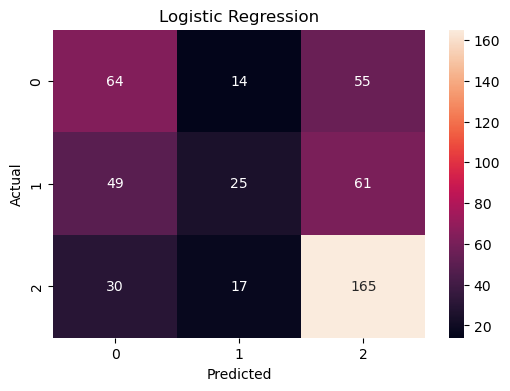

              precision    recall  f1-score   support

           0       0.45      0.48      0.46       133
           1       0.45      0.19      0.26       135
           2       0.59      0.78      0.67       212

    accuracy                           0.53       480
   macro avg       0.49      0.48      0.46       480
weighted avg       0.51      0.53      0.50       480



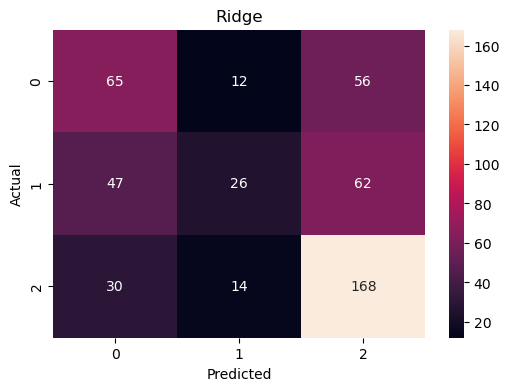

              precision    recall  f1-score   support

           0       0.46      0.49      0.47       133
           1       0.50      0.19      0.28       135
           2       0.59      0.79      0.67       212

    accuracy                           0.54       480
   macro avg       0.52      0.49      0.48       480
weighted avg       0.53      0.54      0.51       480



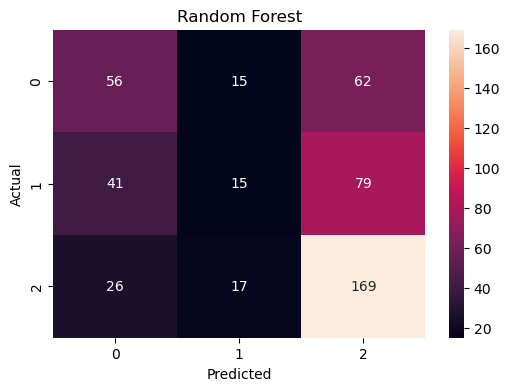

              precision    recall  f1-score   support

           0       0.46      0.42      0.44       133
           1       0.32      0.11      0.16       135
           2       0.55      0.80      0.65       212

    accuracy                           0.50       480
   macro avg       0.44      0.44      0.42       480
weighted avg       0.46      0.50      0.45       480



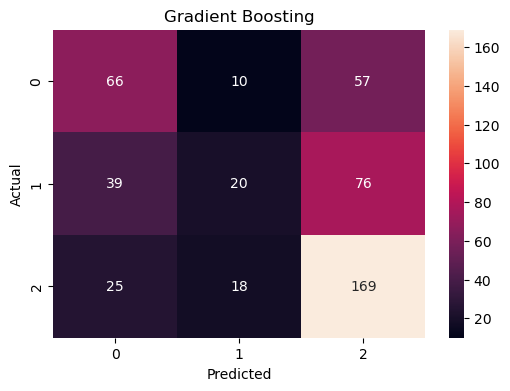

              precision    recall  f1-score   support

           0       0.51      0.50      0.50       133
           1       0.42      0.15      0.22       135
           2       0.56      0.80      0.66       212

    accuracy                           0.53       480
   macro avg       0.49      0.48      0.46       480
weighted avg       0.51      0.53      0.49       480



In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

for name, model in models.items():
    y_pred = model.predict(X_valid)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_valid, y_pred), annot = True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(name)
    plt.show()
    print(classification_report(y_valid, y_pred))

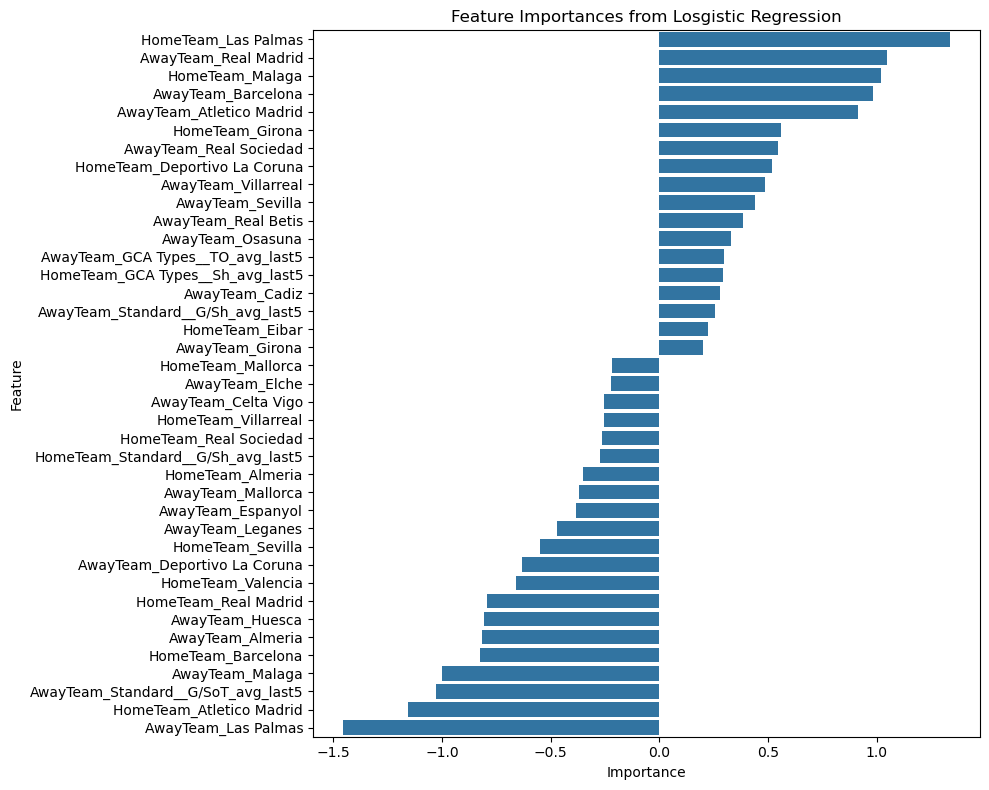

In [42]:
importances = models['Logistic Regression'].coef_[0]
# importances = models['Gradient Boosting'].feature_importances_
feature_names = X_train.columns

# Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df = feature_importance_df[feature_importance_df['Importance'].abs() > 0.2]

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Losgistic Regression')
plt.tight_layout()
plt.show()